<a href="https://colab.research.google.com/github/kisozipaul/ALprojects/blob/main/SMOGN_statististics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install smogn


In [2]:
# ============================================================
# SMOGN augmentation + realism checks (plots + KS test)
# Dataset: integrated_climate_yield_dataset (1).xlsx
# ============================================================

import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import ks_2samp

# ----------------------------
# 0) File paths
# ----------------------------
INPUT_XLSX = r"/content/integrated_climate_yield_dataset (1).xlsx"
OUT_DIR = r"/mnt/data/smogn_outputs"
os.makedirs(OUT_DIR, exist_ok=True)

# ----------------------------
# 1) Load data
# ----------------------------
df = pd.read_excel(INPUT_XLSX)
print("Loaded shape:", df.shape)
print("Columns:", list(df.columns))

# ----------------------------
# 2) Choose target (yield) column
#    - Option A: Set manually (recommended)
# ----------------------------
TARGET_COL = "YIELD"
# If not set, try to auto-detect a yield-like column name
if TARGET_COL is None:
    candidates = []
    for c in df.columns:
        cl = str(c).lower()
        if any(k in cl for k in ["yield", "yld", "t/ha", "t_ha", "tha", "ton", "tons", "production"]):
            candidates.append(c)
    if len(candidates) == 0:
        raise ValueError(
            "Could not auto-detect the yield column. "
            "Please set TARGET_COL manually to the yield/target column name."
        )
    # pick the best candidate: prefer one with 'yield' in it
    candidates_sorted = sorted(candidates, key=lambda x: ("yield" not in str(x).lower(), str(x)))
    TARGET_COL = candidates_sorted[0]

print("Using TARGET_COL:", TARGET_COL)

# ----------------------------
# 3) Basic cleaning
#    - Keep numeric features only (SMOGN needs numeric predictors)
#    - Drop rows with missing target
# ----------------------------
# Drop empty target
df = df.dropna(subset=[TARGET_COL]).copy()

# Separate numeric columns
num_df = df.select_dtypes(include=[np.number]).copy()

if TARGET_COL not in num_df.columns:
    raise ValueError(
        f"Target column '{TARGET_COL}' is not numeric. "
        "Convert it to numeric first or ensure the correct target column is selected."
    )

# Drop columns that are entirely NaN
num_df = num_df.dropna(axis=1, how="all")

# Optional: drop rows with too many NaNs
# (SMOGN can struggle with missing data)
num_df = num_df.dropna(axis=0, how="any").copy()

print("After numeric-only + dropping NaNs -> shape:", num_df.shape)

# ----------------------------
# 4) Install / import SMOGN
# ----------------------------
# If you don't have it installed:
# pip install smogn

try:
    import smogn
except ImportError as e:
    raise ImportError(
        "Package 'smogn' is not installed.\n"
        "Install it using: pip install smogn\n"
        "Then re-run this script."
    ) from e

# ----------------------------
# 5) Apply SMOGN
#    Parameters requested by reviewer:
#    k = 5, pert = 0.01, 100% oversampling
#
# NOTE:
# - 'samp_method' and 'rel_method' can be set; defaults are OK for many cases.
# - 'pert' is the Gaussian perturbation level.
# - If your data is very small, avoid extreme oversampling.
# ----------------------------
K = 5
PERT = 0.01

# In smogn.smoter, "samp_method" is usually "balance" or "extreme".
# "balance" is often safest; it attempts to balance rare/normal regions.
SAMP_METHOD = "balance"

# rel_method = 'auto' uses automatic relevance function estimation
REL_METHOD = "auto"

print("\nRunning SMOGN with:", {"k": K, "pert": PERT, "samp_method": SAMP_METHOD, "rel_method": REL_METHOD})

df_smogn = smogn.smoter(
    data=num_df,
    y=TARGET_COL,
    k=K,
    pert=PERT,
    samp_method=SAMP_METHOD,
    rel_method=REL_METHOD
)

print("SMOGN output shape:", df_smogn.shape)

# ----------------------------
# 6) Save augmented dataset
# ----------------------------
out_xlsx = os.path.join(OUT_DIR, "dataset_smogn_augmented.xlsx")
out_csv = os.path.join(OUT_DIR, "dataset_smogn_augmented.csv")
df_smogn.to_excel(out_xlsx, index=False)
df_smogn.to_csv(out_csv, index=False)
print("Saved augmented dataset to:")
print(" -", out_xlsx)
print(" -", out_csv)

# ----------------------------
# 7) Plots: pre vs post yield distribution
# ----------------------------
y_orig = num_df[TARGET_COL].values
y_aug = df_smogn[TARGET_COL].values

# Histogram overlay
plt.figure()
plt.hist(y_orig, bins=15, alpha=0.6, density=True, label="Original")
plt.hist(y_aug, bins=15, alpha=0.6, density=True, label="Post-SMOGN")
plt.xlabel(TARGET_COL)
plt.ylabel("Density")
plt.title("Yield distribution: Original vs Post-SMOGN (Histogram)")
plt.legend()
hist_path = os.path.join(OUT_DIR, "yield_distribution_hist.png")
plt.tight_layout()
plt.savefig(hist_path, dpi=300)
plt.close()

# Simple KDE (no seaborn; manual gaussian KDE via scipy if available)
try:
    from scipy.stats import gaussian_kde

    kde_orig = gaussian_kde(y_orig)
    kde_aug = gaussian_kde(y_aug)

    xs = np.linspace(min(y_aug.min(), y_orig.min()), max(y_aug.max(), y_orig.max()), 300)

    plt.figure()
    plt.plot(xs, kde_orig(xs), label="Original")
    plt.plot(xs, kde_aug(xs), label="Post-SMOGN")
    plt.xlabel(TARGET_COL)
    plt.ylabel("Density")
    plt.title("Yield distribution: Original vs Post-SMOGN (KDE)")
    plt.legend()
    kde_path = os.path.join(OUT_DIR, "yield_distribution_kde.png")
    plt.tight_layout()
    plt.savefig(kde_path, dpi=300)
    plt.close()
except Exception as e:
    print("KDE plot skipped (scipy gaussian_kde not available or failed):", e)
    kde_path = None

print("Saved plots to:")
print(" -", hist_path)
if kde_path:
    print(" -", kde_path)

# ----------------------------
# 8) KS test: original vs post-SMOGN yield distributions
# ----------------------------
# Note: With augmentation, n differs; KS is still valid for comparing distributions.
ks_stat, p_value = ks_2samp(y_orig, y_aug, alternative="two-sided", mode="auto")

ks_report = pd.DataFrame([{
    "comparison": f"Original vs Post-SMOGN ({TARGET_COL})",
    "n_original": len(y_orig),
    "n_post_smogn": len(y_aug),
    "KS_statistic_D": ks_stat,
    "p_value": p_value
}])

ks_path = os.path.join(OUT_DIR, "ks_test_results.csv")
ks_report.to_csv(ks_path, index=False)

print("\nKS Test results")
print(ks_report.to_string(index=False))
print("Saved KS report to:", ks_path)

# ----------------------------
# 9) Quick biophysical sanity checks (optional)
#    - print min/max and show whether SMOGN exceeds observed bounds
# ----------------------------
print("\nSanity check (yield bounds):")
print("Original min/max:", float(np.min(y_orig)), float(np.max(y_orig)))
print("Post-SMOGN min/max:", float(np.min(y_aug)), float(np.max(y_aug)))

if np.max(y_aug) > np.max(y_orig) * 1.05:
    print("WARNING: SMOGN produced yields >5% above observed max. Consider lowering 'pert' or using 'extreme'/'balance' settings carefully.")
if np.min(y_aug) < np.min(y_orig) * 0.95:
    print("WARNING: SMOGN produced yields >5% below observed min. Consider lowering 'pert'.")

print("\nDone. Outputs folder:", OUT_DIR)


Loaded shape: (60, 8)
Columns: ['ZARDI', 'YEAR', 'SOIL_MOISTURE', 'RAINFALL', 'SOLAR_RAD', 'MAX_TEMP', 'MIN_TEMP', 'YIELD']
Using TARGET_COL: YIELD
After numeric-only + dropping NaNs -> shape: (60, 6)

Running SMOGN with: {'k': 5, 'pert': 0.01, 'samp_method': 'balance', 'rel_method': 'auto'}


synth_matrix: 100%|##########| 6/6 [00:00<00:00, 22.93it/s]


SMOGN output shape: (54, 6)
Saved augmented dataset to:
 - /mnt/data/smogn_outputs/dataset_smogn_augmented.xlsx
 - /mnt/data/smogn_outputs/dataset_smogn_augmented.csv
Saved plots to:
 - /mnt/data/smogn_outputs/yield_distribution_hist.png
 - /mnt/data/smogn_outputs/yield_distribution_kde.png

KS Test results
                    comparison  n_original  n_post_smogn  KS_statistic_D  p_value
Original vs Post-SMOGN (YIELD)          60            54        0.455556 0.000007
Saved KS report to: /mnt/data/smogn_outputs/ks_test_results.csv

Sanity check (yield bounds):
Original min/max: 0.6 4.0
Post-SMOGN min/max: 0.9 4.5

Done. Outputs folder: /mnt/data/smogn_outputs


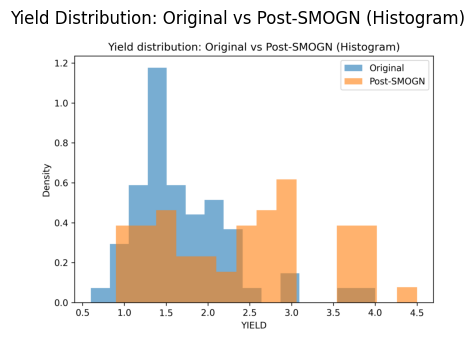

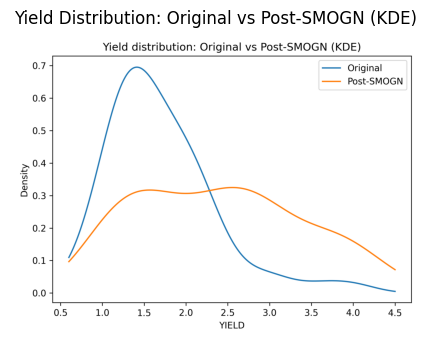

In [3]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Paths to saved figures
hist_path = "/mnt/data/smogn_outputs/yield_distribution_hist.png"
kde_path = "/mnt/data/smogn_outputs/yield_distribution_kde.png"

# Display histogram
img = mpimg.imread(hist_path)
plt.figure(figsize=(6,4))
plt.imshow(img)
plt.axis("off")
plt.title("Yield Distribution: Original vs Post-SMOGN (Histogram)")
plt.show()

# Display KDE
img = mpimg.imread(kde_path)
plt.figure(figsize=(6,4))
plt.imshow(img)
plt.axis("off")
plt.title("Yield Distribution: Original vs Post-SMOGN (KDE)")
plt.show()


Loaded: (60, 8)
Columns: ['ZARDI', 'YEAR', 'SOIL_MOISTURE', 'RAINFALL', 'SOLAR_RAD', 'MAX_TEMP', 'MIN_TEMP', 'YIELD']
Numeric cleaned: (60, 6)
Observed YIELD min/max: 0.6 4.0


synth_matrix: 100%|##########| 6/6 [00:00<00:00, 64.71it/s]


Seed 1: added 48 new rows -> total 108


synth_matrix: 100%|##########| 6/6 [00:00<00:00, 64.98it/s]


Seed 2: added 48 new rows -> total 156


synth_matrix: 100%|##########| 6/6 [00:00<00:00, 90.88it/s]


Seed 3: added 48 new rows -> total 204


synth_matrix: 100%|##########| 6/6 [00:00<00:00, 98.00it/s]


Seed 4: added 48 new rows -> total 252


synth_matrix: 100%|##########| 6/6 [00:00<00:00, 86.77it/s]


Seed 5: added 48 new rows -> total 300
Final augmented size: (295, 6)
Saved: /mnt/data/smogn_outputs_295/dataset_smogn_augmented_295.xlsx
Saved: /mnt/data/smogn_outputs_295/dataset_smogn_augmented_295.csv
Saved KS tests: /mnt/data/smogn_outputs_295/ks_tests_original_vs_augmented.csv
     variable  n_original  n_augmented     KS_D      p_value
        YIELD          60          295 0.716949 8.841105e-26
SOIL_MOISTURE          60          295 0.144068 2.267221e-01
     RAINFALL          60          295 0.315819 6.484709e-05
    SOLAR_RAD          60          295 0.325989 3.274457e-05
     MAX_TEMP          60          295 0.237006 5.965362e-03
     MIN_TEMP          60          295 0.250282 3.060704e-03


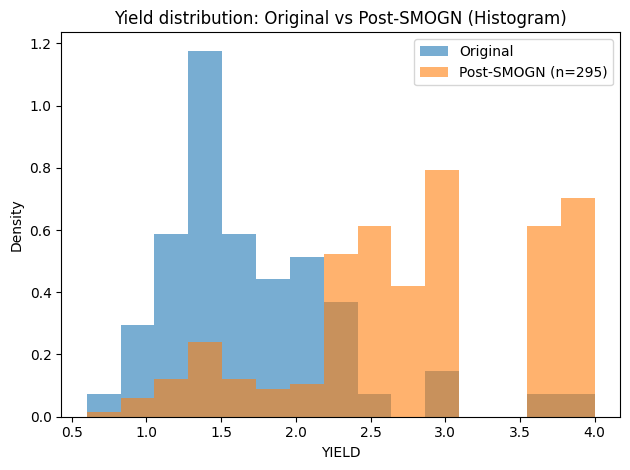

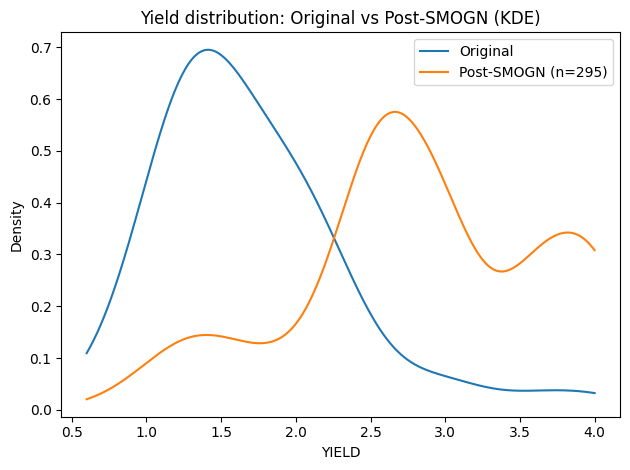

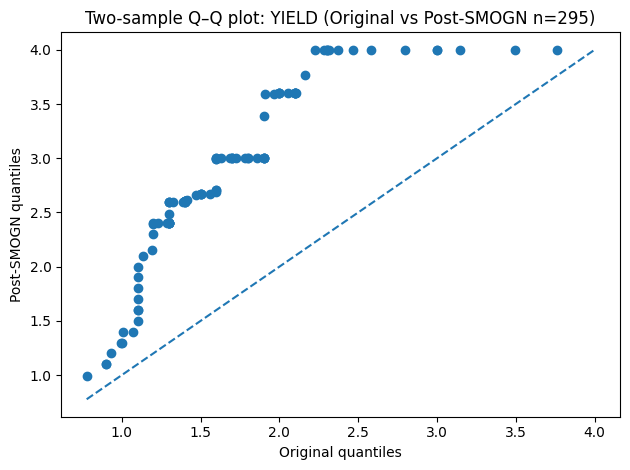

Saved Q–Q plot: /mnt/data/smogn_outputs_295/qqplot_yield_original_vs_smogn_295.png

Yield bounds check:
Original min/max: 0.6 4.0
Augmented min/max: 0.6 4.0

All outputs in: /mnt/data/smogn_outputs_295


In [4]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import ks_2samp
from scipy.stats import gaussian_kde

# ----------------------------
# Settings
# ----------------------------
INPUT_XLSX = r"/content/integrated_climate_yield_dataset (1).xlsx"
OUT_DIR = r"/mnt/data/smogn_outputs_295"
os.makedirs(OUT_DIR, exist_ok=True)

TARGET_COL = "YIELD"
TARGET_N = 295

# SMOGN params (start with conservative noise to avoid unrealistic extremes)
K = 5
PERT = 0.005
SAMP_METHOD = "extreme"   # tends to avoid trimming "normal" samples vs "balance"
REL_METHOD = "auto"

# Optional: clamp YIELD to observed bounds (helps with biophysical realism)
CLAMP_TARGET_TO_OBSERVED_BOUNDS = True

# ----------------------------
# Load data
# ----------------------------
df = pd.read_excel(INPUT_XLSX)
print("Loaded:", df.shape)
print("Columns:", list(df.columns))

# Keep numeric columns only (SMOGN expects numeric predictors)
num_df = df.select_dtypes(include=[np.number]).copy()

# Drop rows missing target
num_df = num_df.dropna(subset=[TARGET_COL]).copy()

# Drop columns entirely NA and rows with any NA (simple, robust)
num_df = num_df.dropna(axis=1, how="all")
num_df = num_df.dropna(axis=0, how="any").copy()

print("Numeric cleaned:", num_df.shape)

# Observed bounds for realism checks
y_min_obs = float(num_df[TARGET_COL].min())
y_max_obs = float(num_df[TARGET_COL].max())
print("Observed YIELD min/max:", y_min_obs, y_max_obs)

# ----------------------------
# Import smogn
# ----------------------------
import smogn

# ----------------------------
# Helper: identify "new synthetic" rows
# We'll use row-wise hashing after rounding (robust to floating jitter).
# ----------------------------
def hash_rows(df_in: pd.DataFrame, round_decimals: int = 6) -> pd.Series:
    df_r = df_in.round(round_decimals).copy()
    # Convert rows to a single string then hash
    return pd.util.hash_pandas_object(df_r.astype(str).agg("|".join, axis=1), index=False)

orig_hash = set(hash_rows(num_df).tolist())

# We'll build an augmented pool that starts with original
aug_pool = num_df.copy()
aug_hash = set(orig_hash)

# ----------------------------
# SMOGN loop until TARGET_N
# ----------------------------
seed = 1
max_iters = 200  # safety cap
added_total = 0

while len(aug_pool) < TARGET_N and seed <= max_iters:
    np.random.seed(seed)

    df_sm = smogn.smoter(
        data=num_df,
        y=TARGET_COL,
        k=K,
        pert=PERT,
        samp_method=SAMP_METHOD,
        rel_method=REL_METHOD
    )

    # Find rows that are NOT already in aug_pool (new synthetics)
    h = hash_rows(df_sm)
    is_new = ~h.isin(list(aug_hash))
    new_rows = df_sm.loc[is_new].copy()

    # Optional: clamp synthetic YIELD to observed bounds to ensure realism
    if CLAMP_TARGET_TO_OBSERVED_BOUNDS and len(new_rows) > 0:
        new_rows[TARGET_COL] = new_rows[TARGET_COL].clip(lower=y_min_obs, upper=y_max_obs)

    # Re-hash after clamping (so we don't add duplicates)
    if len(new_rows) > 0:
        h2 = hash_rows(new_rows)
        is_new2 = ~h2.isin(list(aug_hash))
        new_rows = new_rows.loc[is_new2].copy()

    if len(new_rows) > 0:
        aug_pool = pd.concat([aug_pool, new_rows], ignore_index=True)
        for hv in hash_rows(new_rows).tolist():
            aug_hash.add(hv)

        added_total += len(new_rows)
        print(f"Seed {seed}: added {len(new_rows)} new rows -> total {len(aug_pool)}")

    seed += 1

if len(aug_pool) < TARGET_N:
    raise RuntimeError(
        f"Could not reach TARGET_N={TARGET_N}. Got {len(aug_pool)}. "
        f"Try increasing max_iters, or slightly increasing PERT (e.g., 0.01)."
    )

# Trim to exact target size
aug_final = aug_pool.iloc[:TARGET_N].copy()
print("Final augmented size:", aug_final.shape)

# Save augmented dataset
out_xlsx = os.path.join(OUT_DIR, "dataset_smogn_augmented_295.xlsx")
out_csv = os.path.join(OUT_DIR, "dataset_smogn_augmented_295.csv")
aug_final.to_excel(out_xlsx, index=False)
aug_final.to_csv(out_csv, index=False)
print("Saved:", out_xlsx)
print("Saved:", out_csv)

# ----------------------------
# KS tests: original vs augmented
# ----------------------------
y_orig = num_df[TARGET_COL].values
y_aug = aug_final[TARGET_COL].values

ks_stat, p_val = ks_2samp(y_orig, y_aug, alternative="two-sided", mode="auto")
ks_rows = [{
    "variable": TARGET_COL,
    "n_original": len(y_orig),
    "n_augmented": len(y_aug),
    "KS_D": float(ks_stat),
    "p_value": float(p_val)
}]

# OPTIONAL: also compute KS for each predictor (some reviewers like this)
for c in num_df.columns:
    if c == TARGET_COL:
        continue
    ks_stat_c, p_val_c = ks_2samp(num_df[c].values, aug_final[c].values, alternative="two-sided", mode="auto")
    ks_rows.append({
        "variable": c,
        "n_original": len(num_df[c].values),
        "n_augmented": len(aug_final[c].values),
        "KS_D": float(ks_stat_c),
        "p_value": float(p_val_c)
    })

ks_df = pd.DataFrame(ks_rows)
ks_path = os.path.join(OUT_DIR, "ks_tests_original_vs_augmented.csv")
ks_df.to_csv(ks_path, index=False)
print("Saved KS tests:", ks_path)
print(ks_df.to_string(index=False))

# ----------------------------
# Plot 1: Histogram overlay (Yield)
# ----------------------------
plt.figure()
plt.hist(y_orig, bins=15, alpha=0.6, density=True, label="Original")
plt.hist(y_aug, bins=15, alpha=0.6, density=True, label="Post-SMOGN (n=295)")
plt.xlabel(TARGET_COL)
plt.ylabel("Density")
plt.title("Yield distribution: Original vs Post-SMOGN (Histogram)")
plt.legend()
hist_path = os.path.join(OUT_DIR, "yield_hist_original_vs_smogn_295.png")
plt.tight_layout()
plt.savefig(hist_path, dpi=300)
plt.show()

# ----------------------------
# Plot 2: KDE overlay (Yield)
# ----------------------------
kde_orig = gaussian_kde(y_orig)
kde_aug = gaussian_kde(y_aug)

xs = np.linspace(min(y_orig.min(), y_aug.min()), max(y_orig.max(), y_aug.max()), 300)
plt.figure()
plt.plot(xs, kde_orig(xs), label="Original")
plt.plot(xs, kde_aug(xs), label="Post-SMOGN (n=295)")
plt.xlabel(TARGET_COL)
plt.ylabel("Density")
plt.title("Yield distribution: Original vs Post-SMOGN (KDE)")
plt.legend()
kde_path = os.path.join(OUT_DIR, "yield_kde_original_vs_smogn_295.png")
plt.tight_layout()
plt.savefig(kde_path, dpi=300)
plt.show()

# ----------------------------
# Plot 3: Two-sample Q–Q plot (Yield)
# Q–Q: quantiles of augmented vs quantiles of original
# ----------------------------
def qq_two_sample(x, y, n_quantiles=100):
    x = np.asarray(x)
    y = np.asarray(y)
    qs = np.linspace(0.01, 0.99, n_quantiles)
    xq = np.quantile(x, qs)
    yq = np.quantile(y, qs)

    plt.figure()
    plt.scatter(xq, yq)
    # 45-degree reference line
    lo = min(xq.min(), yq.min())
    hi = max(xq.max(), yq.max())
    plt.plot([lo, hi], [lo, hi], linestyle="--")
    plt.xlabel("Original quantiles")
    plt.ylabel("Post-SMOGN quantiles")
    plt.title(f"Two-sample Q–Q plot: {TARGET_COL} (Original vs Post-SMOGN n=295)")
    qq_path = os.path.join(OUT_DIR, "qqplot_yield_original_vs_smogn_295.png")
    plt.tight_layout()
    plt.savefig(qq_path, dpi=300)
    plt.show()
    return qq_path

qq_path = qq_two_sample(y_orig, y_aug)
print("Saved Q–Q plot:", qq_path)

# ----------------------------
# Sanity checks
# ----------------------------
print("\nYield bounds check:")
print("Original min/max:", float(y_orig.min()), float(y_orig.max()))
print("Augmented min/max:", float(y_aug.min()), float(y_aug.max()))
print("\nAll outputs in:", OUT_DIR)


In [5]:
import pandas as pd

ks_path = "/mnt/data/smogn_outputs_295/ks_tests_original_vs_augmented.csv"
ks_df = pd.read_csv(ks_path)

print(ks_df)


        variable  n_original  n_augmented      KS_D       p_value
0          YIELD          60          295  0.716949  8.841105e-26
1  SOIL_MOISTURE          60          295  0.144068  2.267221e-01
2       RAINFALL          60          295  0.315819  6.484709e-05
3      SOLAR_RAD          60          295  0.325989  3.274457e-05
4       MAX_TEMP          60          295  0.237006  5.965362e-03
5       MIN_TEMP          60          295  0.250282  3.060704e-03
